In [54]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

In [55]:
project_root = os.getcwd()
while "src" not in os.listdir(project_root):
    project_root = os.path.dirname(project_root)

data_root = os.path.join(project_root, "data", "processed", "train")

if not os.path.exists(data_root):
    raise FileNotFoundError("No se encontró la carpeta data, por favor ejecute el script download_data.sh antes de ejecutar este script.")

In [56]:
class Sample:
    def __init__(self, path):
        self.path = path
        self.name = os.path.basename(path)
        self.data = np.load(path, allow_pickle=True).item()
        self.mixture = self.data["mixture"]
        self.bass = self.data["bass"]
        self.drums = self.data["drums"]
        self.other = self.data["other"]
        self.vocals = self.data["vocals"]

    def __repr__(self):
        return f"Sample({self.name})"

    def __str__(self):
        return self.__repr__()

    def plot(self):
        # Plot the mixture spectrogram
        plt.figure(figsize=(10, 10))
        plt.title("Mixture")
        plt.imshow(self.mixture.T, aspect="auto", origin="lower")
        plt.colorbar()

In [57]:
random_sample = random.choice(os.listdir(data_root))
sample_path = os.path.join(data_root, random_sample)
sample = Sample(sample_path)

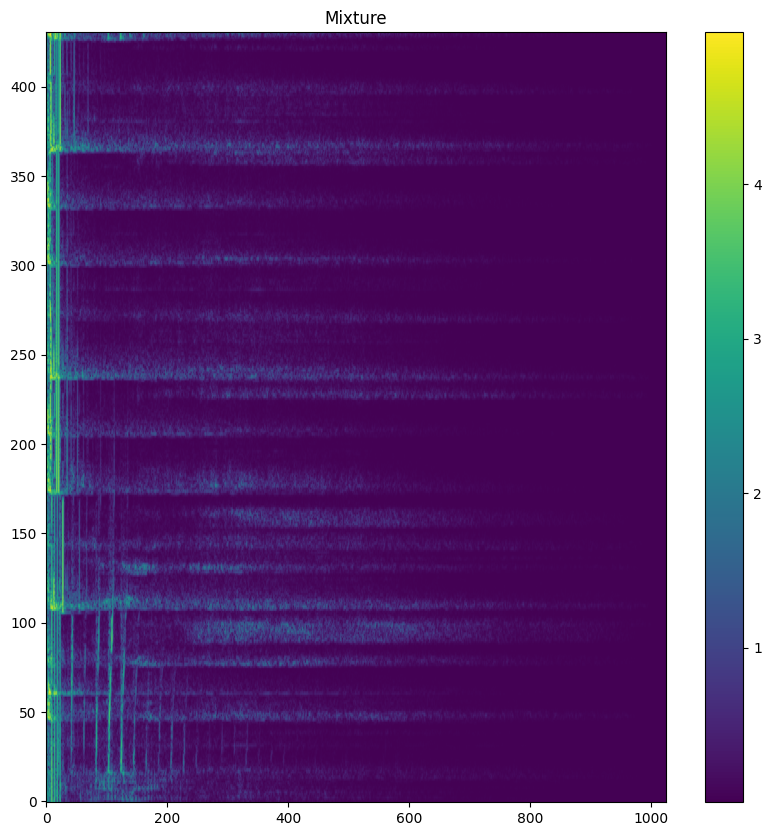

In [58]:
sample.plot()